<div class='bar_title'></div>

*Introduction to Data Science (IDS)*

# Assignment 11 - Time Series Analysis Solutions
Gunther Gust / Vanessa Haustein <br>
Chair for Enterprise AI<br>
Data Driven Decisions (D3) Group<br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/d3.png?raw=true' style='width:20%; float:left;' />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/CAIDASlogo.png" style="width:20%; float:left;" />


# Exercise 1: Onion Price Forecast in Bangalore

We want to predict the onion **prices** in Bangalore for the future using an ARIMA model. For this, we will use the cleaned MonthWiseMarketArrivals dataset:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss
from lets_plot import *
LetsPlot.setup_html()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/MonthWiseMarketArrivals_Clean.csv')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In order to be able to work properly with our dataset we need some preprocessing steps:
1. Change the date column to a Datetime Index column
2. Set the date as index
3. Sort the data frame by the new index

Thses steps are necessary to ensure that our model will later be able to understand the relationship between the date (and its frequency in months) and the value (the price) for fitting a model and forecasting.

In [3]:
# Change the date column to a Time Interval columnn
df['date'] = pd.DatetimeIndex(df['date'])

# Change the index to the date column
df.set_index('date', inplace=True, drop=False)

# Sort the data frame by date
df.sort_index(inplace=True)

df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02-01,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03-01,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04-01,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05-01,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


We want to make our predictions only for Bangalore, so we have to filter our dataset for relevant observations. Additionally, the only information we will use in our model are the `date`, the `priceMod` and (for the second exercise) the `quantity`.

In [4]:
dfBang = df.loc[df.city == "BANGALORE"][['date', 'quantity', 'priceMod']].copy()
dfBang.head()

,date,quantity,priceMod
date,,,
2004-01-01,2004-01-01,227832,991
2004-02-01,2004-02-01,225133,793
2004-03-01,2004-03-01,221952,556
2004-04-01,2004-04-01,185150,465
2004-05-01,2004-05-01,137390,455


Plot the columns `priceMod` and `quantity` in two different plots.

In [5]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='quantity'))
    + ggsize(1000, 400)
)

In [6]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceMod'))
    + ggsize(1000, 400)
)

What do you observe about the data?

_Quantity:_

There is an obvious seasonal trend of one year length in the data. Additionally, the overall sales seem to have increased slightly over the years.

_priceMod:_

The data exhibits fluctuations in the spread or amplitude of the values over time, leading to the observation that the data is not stationary.

Now let's focus on the **price** development of onions in Bangalore. investigate the stationarity of the price timeseries. Check this visually and with a KPSS test. Depending on the result of your inspection, take measures to turn the data into a stationary timeseries and confirm that it worked.

In [7]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceMod'))
    + ggsize(1000, 400)
)

In [8]:
kpss(dfBang['priceMod'])

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_23996\2874154983.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(dfBang['priceMod'])


(1.261517249967608,
 0.01,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The model is not stationary. 

In [9]:
dfBang["priceModDiff"] = dfBang.priceMod.diff(1)

In [10]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceModDiff'))
    + ggsize(1000, 400)
)

In [11]:
kpss(dfBang['priceModDiff'].dropna())[1]

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_23996\330805533.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(dfBang['priceModDiff'].dropna())[1]


0.1

What does this mean for the parameter $d$ of the ARIMA model $(p, d, q)$?

The first order differenciation helped turn our data into a stationary timeseries. This means, that if we were to choose the parameters manually, we would select $d=1$.

## Auto ARIMA
We already found out that our data is not stationary. Now, we will see if Auto ARIMA makes the same choice as we would with the information from the above stationarity check. Find the parameters using the `auto_arima` function on the price timeseries and choose an appropriate model selection metric. Check the residuals for the best model you could find. Set `seasonal=false`.

In [13]:
ts_Bang = dfBang['priceMod']

auto_model = auto_arima(ts_Bang, information_criterion='aicc', trace=True, seasonal=False)
auto_model.summary()

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=2091.626, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=2064.428, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=2053.623, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=2089.571, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=2055.633, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=2055.614, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AICC=2051.535, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AICC=2053.521, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AICC=2053.500, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AICC=2062.338, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AICC=2040.244, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AICC=2034.576, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  146
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1012.360
Date:                Tue, 20 Jan 2026   AIC                           2032.720
Time:                        07:21:22   BIC                           2044.627
Sample:                    01-01-2004   HQIC                          2037.558
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2644      0.069     18.388      0.000       1.130       1.399
ar.L2         -0.5736      0.053    -10.821      0.000      -0.677      -0.470
ma.L1         -0.9235      0.046    -20.054      0.000      -1.014      -0.833
sigma2      6.721e+04   4850.299     13.856      0.000    5.77e+04    7.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               116.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.89   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

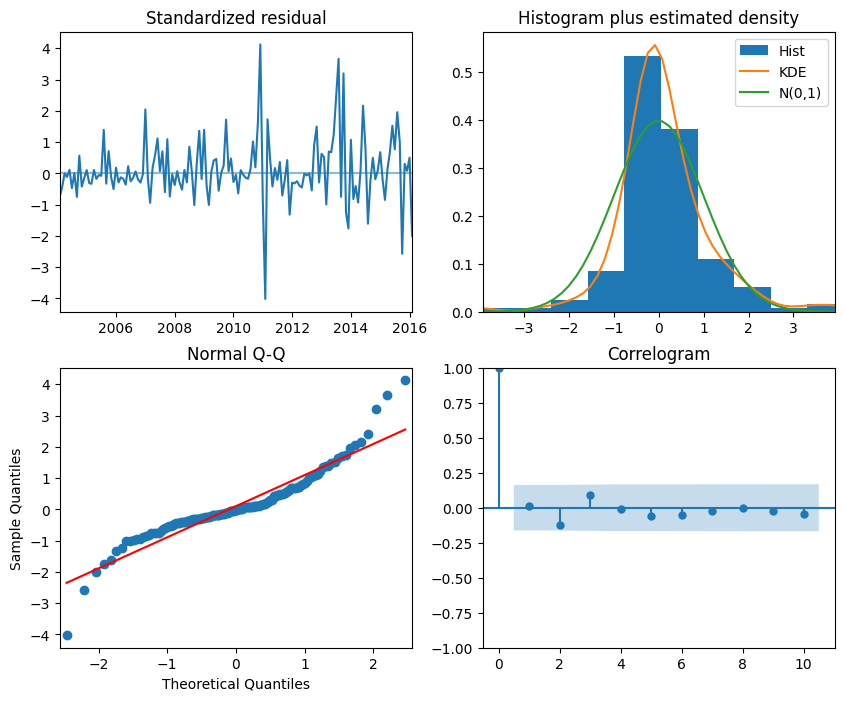

In [14]:
auto_model.plot_diagnostics(figsize=(10,8))
plt.show()

Next, we examine whether the price time series shows a repeating seasonal pattern. Identify the most plausible seasonal period m and fit an Auto-ARIMA model with `seasonal=True` and your chosen value of m. Decide, if it was a good idea to add the seasonal component or not.

In [15]:
auto_model_seasonal = auto_arima(ts_Bang, information_criterion='aicc', trace=True, seasonal=True, m=12)
auto_model_seasonal.summary()

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AICC=inf, Time=3.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=2091.626, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=2065.981, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=2055.359, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=2089.571, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AICC=2053.623, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AICC=2055.235, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AICC=inf, Time=1.58 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AICC=2055.633, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AICC=2055.614, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AICC=2064.428, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AICC=inf, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AICC=2051.535, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AICC=2053.118, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  146
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1012.360
Date:                Tue, 20 Jan 2026   AIC                           2032.720
Time:                        07:22:02   BIC                           2044.627
Sample:                    01-01-2004   HQIC                          2037.558
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2644      0.069     18.388      0.000       1.130       1.399
ar.L2         -0.5736      0.053    -10.821      0.000      -0.677      -0.470
ma.L1         -0.9235      0.046    -20.054      0.000      -1.014      -0.833
sigma2      6.721e+04   4850.299     13.856      0.000    5.77e+04    7.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               116.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.89   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that Auto-SARIMA selects the same model parameters as Auto-ARIMA. This indicates that the time series does not exhibit a seasonal pattern strong enough for the algorithm to include seasonal components in the final model.

# Exercise 2: Onion Quantity Forecast in Bangalore

Now, use the prophet package to forecast the **quantity** of onion sales in Bangalore for the next 3 years. Plot your results as well as the decomposition of the timeseries. Discuss why Prophet could be a good choice for this dataset, and explain in which situations an ARIMA/SARIMA model might still be the better option.

In [ ]:
dfBang

,date,quantity,priceMod,priceModLog,priceModLogDiff
date,,,,,
2004-01-01,2004-01-01,227832,991,6.898715,NaN
2004-02-01,2004-02-01,225133,793,6.675823,-0.222891
2004-03-01,2004-03-01,221952,556,6.320768,-0.355055
2004-04-01,2004-04-01,185150,465,6.142037,-0.178731
2004-05-01,2004-05-01,137390,455,6.120297,-0.021740
...,...,...,...,...,...
2015-10-01,2015-10-01,1612160,2215,7.703008,-0.348970
2015-11-01,2015-11-01,1071872,1618,7.388946,-0.314062
2015-12-01,2015-12-01,513186,1343,7.202661,-0.186285


In [ ]:
df = dfBang[['date', 'quantity']].copy()
df.rename(columns={'date': 'ds', 'quantity': 'y'}, inplace=True)

m = Prophet()
m.fit(df)

17:23:48 - cmdstanpy - INFO - Chain [1] start processing
17:23:49 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\vah55ns\Documents\src\IDS\env\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 1600x1000 with 0 Axes>

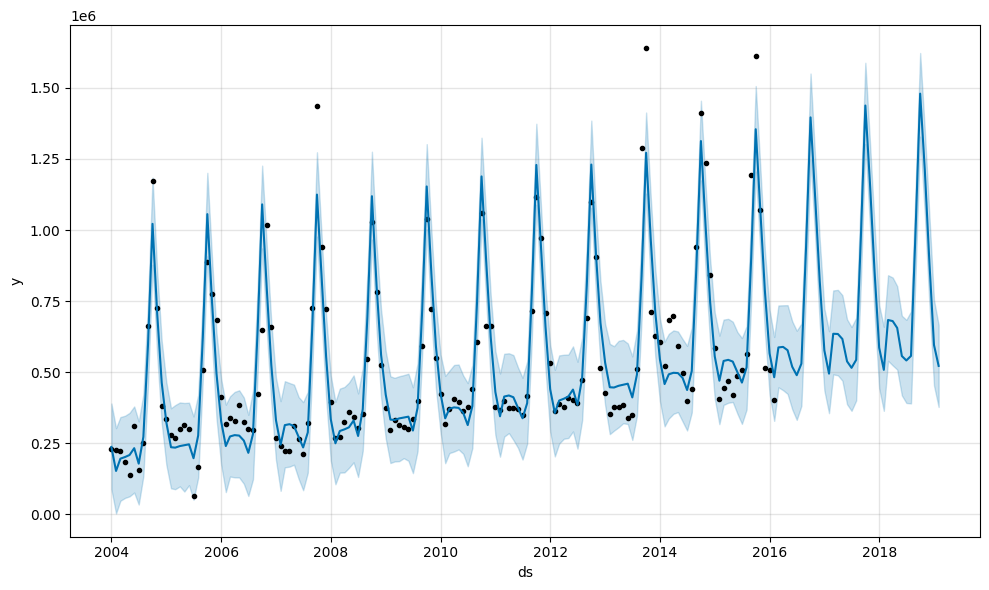

In [ ]:
future = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future)

plt.figure(figsize=(16, 10))
m.plot(forecast)
plt.show()

<Figure size 1600x1000 with 0 Axes>

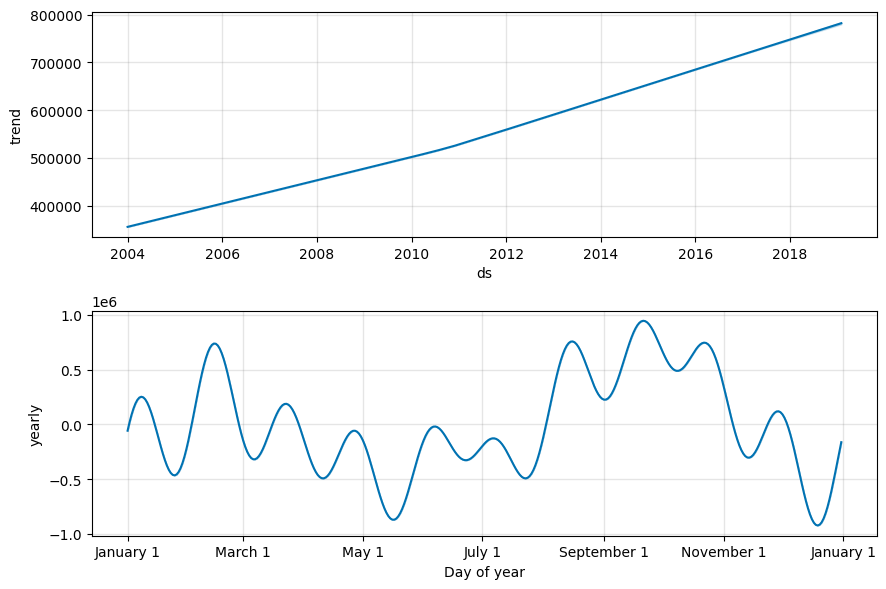

In [ ]:
plt.figure(figsize=(16, 10))
m.plot_components(forecast)
plt.show()

Prophet is a strong baseline when data has trend and clear seasonality and we want a model that is easy to apply.
However, ARIMA/SARIMA may perform better when the time series mainly follows short-term autocorrelation patterns or when we carefully tune model parameters.
In practice, it’s best to compare both using a test set and choose the model with the best forecast accuracy.

# Exercise 3: Dealing with Non-Stationarity

Here are plots of three different datasets. Which one of these is stationary? Link them to their appropriate ACF/PACF plots.

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/stationarity_check.png' style='width:90%; float:left;' />

ACF plots:

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/output_acf.png' style='width:90%; float:left;' />


PACF plots:

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/output_pacf.png' style='width:90%; float:left;' />


**Daily total female births**:

The data appears stationary, fluctuating around a constant mean with no apparent trend or seasonality.
This aligns with Data 3.

**international airlane passengers**:
The data shows a clear upward trend with seasonal fluctuations.
This pattern matches Data, where the ACF shows a slow decay (indicative of an AR process), and the PACF cuts off sharply after lag 1.

**shampoo sales**:

Strong upward trend: This dataset shows a steady upward trend but weaker seasonal behavior compared to the second dataset.
This corresponds to Data 2, where the ACF shows a damped sinusoidal pattern and the PACF cuts off after lag 2